# Data Processing of YouTube Data

Includes running some regression and predictive ML algorithms

In [168]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [152]:
def adj_r2_score(y, y_pred, X):
    return 1 - (1-r2_score(y, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)

## Read data from BQ

In [2]:
gcs_project_id = "wide-hexagon-397214"
gcs_dataset  = "youtube_data"

**Channel Data**

In [3]:
query_channel = """

SELECT *
FROM `{gcs_project_id}.{gcs_dataset}.{table_name}`

""".format(gcs_project_id=gcs_project_id,
           gcs_dataset=gcs_dataset,
           table_name="channel_info"
          )

In [4]:
channel_info = pd.read_gbq(query_channel,
                           project_id=gcs_project_id,
                           dialect="standard",
                           progress_bar_type="tqdm")

print(channel_info.shape)
channel_info.head(5)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████|
(36, 7)


,channel_name,view_count,subscriber_count,video_count,channel_id,playlist_id,load_timestamp
0,Harsh Kumar,76429,705,14,UCueeXkuJezkCqu0YryvJnnQ,UUueeXkuJezkCqu0YryvJnnQ,2023-10-16 12:03:46.700888+00:00
1,Thu Vu data analytics,5514835,169000,75,UCJQJAI7IjbLcpsjWdSzYz0Q,UUJQJAI7IjbLcpsjWdSzYz0Q,2023-10-16 12:03:46.700888+00:00
2,amitvarma,144823,5740,16,UCs8a-hjf6X4pa-O0orSoC8w,UUs8a-hjf6X4pa-O0orSoC8w,2023-10-16 12:03:46.700888+00:00
3,Harsh Kumar,76490,706,14,UCueeXkuJezkCqu0YryvJnnQ,UUueeXkuJezkCqu0YryvJnnQ,2023-10-17 12:01:16.334389+00:00
4,Thu Vu data analytics,5520237,169000,76,UCJQJAI7IjbLcpsjWdSzYz0Q,UUJQJAI7IjbLcpsjWdSzYz0Q,2023-10-17 12:01:16.334389+00:00


**Video Data**

In [5]:
query_channel = """

SELECT *
FROM `{gcs_project_id}.{gcs_dataset}.{table_name}`

""".format(gcs_project_id=gcs_project_id,
           gcs_dataset=gcs_dataset,
           table_name="video_details"
          )

In [6]:
video_details = pd.read_gbq(query_channel,
                           project_id=gcs_project_id,
                           dialect="standard",
                           progress_bar_type="tqdm")

print(video_details.shape)
video_details.head(5)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████|
(108, 8)


,video_id,title,published_at,view_count,like_count,comment_count,duration_sec,load_timestamp
0,rs8_I0sYGhw,isort for sorting Python imports #shorts #pyth...,2023-03-26 13:41:44+00:00,199,6,0,56.0,2023-10-28 18:02:56.106892+00:00
1,bhjaQssIXiw,pytest Tutorial: How to write tests in Python ...,2023-02-06 14:06:40+00:00,93,6,0,688.0,2023-10-28 18:02:56.106892+00:00
2,bURvz4g-XIg,flake8 for linting in Python #shorts #python #...,2023-03-19 18:34:57+00:00,124,7,1,53.0,2023-10-28 18:02:56.106892+00:00
3,GIEp0zNwtBA,Ranking Functions in SQL (Rank vs Dense_Rank v...,2021-06-22 14:50:31+00:00,458,14,1,254.0,2023-10-28 18:02:56.106892+00:00
4,uN1G1sZlELs,Decision Tree in Python using Scikit-Learn | T...,2021-04-01 13:35:45+00:00,10517,121,2,964.0,2023-10-28 18:02:56.106892+00:00


In [7]:
video_details.dtypes

video_id                       object
title                          object
published_at      datetime64[us, UTC]
view_count                      Int64
like_count                      Int64
comment_count                   Int64
duration_sec                  float64
load_timestamp    datetime64[us, UTC]
dtype: object

In [8]:
video_details = video_details.astype({
    "view_count": float,
    "like_count": float,
    "comment_count": float,
})

video_details.dtypes

video_id                       object
title                          object
published_at      datetime64[us, UTC]
view_count                    float64
like_count                    float64
comment_count                 float64
duration_sec                  float64
load_timestamp    datetime64[us, UTC]
dtype: object

## Summary Statistics

<Axes: xlabel='load_timestamp', ylabel='subscriber_count'>

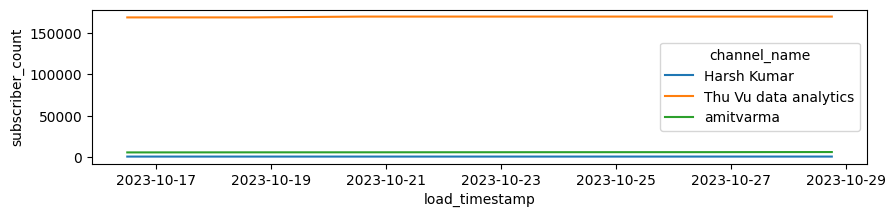

In [9]:
f, axs = plt.subplots(figsize=(10,2))
sns.lineplot(data=channel_info,
            x="load_timestamp",
            y="subscriber_count",
            hue="channel_name")

In [10]:
max_loadtime = channel_info.load_timestamp.max()
latest_channel_info = channel_info.loc[channel_info["load_timestamp"]==max_loadtime].copy()

In [11]:
latest_channel_info.describe(percentiles=[0.2,0.4,0.6,0.8])

,view_count,subscriber_count,video_count
count,3.0,3.0,3.0
mean,1940441.666667,58966.666667,36.0
std,3150142.311011,96196.717373,34.698703
min,76980.0,710.0,14.0
20%,112908.8,2902.0,15.6
40%,148837.6,5094.0,17.2
50%,166802.0,6190.0,18.0
60%,1248950.2,38952.0,29.6
80%,3413246.6,104476.0,52.8
max,5577543.0,170000.0,76.0


<Axes: xlabel='channel_name', ylabel='subscriber_count'>

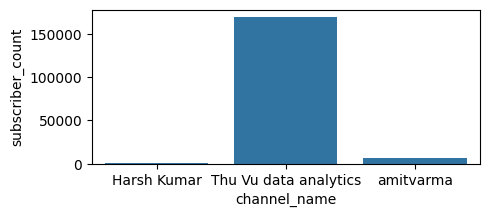

In [12]:
f, axs = plt.subplots(figsize=(5,2))
sns.barplot(data=latest_channel_info,
            x="channel_name",
            y="subscriber_count")

## Regression Plots

<Axes: xlabel='view_count', ylabel='like_count'>

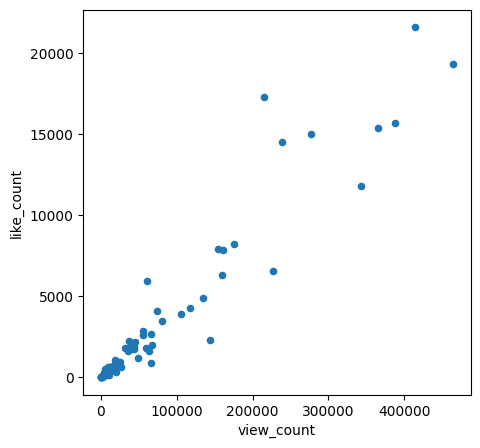

In [13]:
f, axs = plt.subplots(figsize=(5,5))
video_details.plot(x="view_count", y="like_count", kind="scatter", ax=axs)

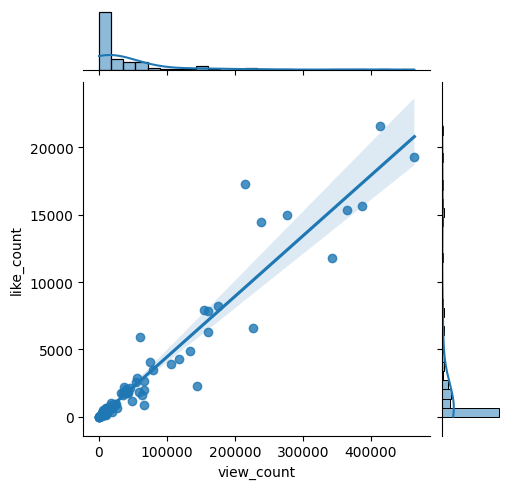

In [14]:
sns.jointplot(data=video_details, x="view_count", y="like_count", kind="reg", height=5)

## Correlations

In [32]:
np.corrcoef(video_details["view_count"], video_details["like_count"])

array([[1.        , 0.95923655],
       [0.95923655, 1.        ]])

In [15]:
video_details[["view_count","like_count","comment_count", "duration_sec"]].corr()

,view_count,like_count,comment_count,duration_sec
view_count,1.000000,0.959237,0.821475,-0.206658
like_count,0.959237,1.000000,0.756986,-0.212720
comment_count,0.821475,0.756986,1.000000,-0.102318
duration_sec,-0.206658,-0.212720,-0.102318,1.000000


In [34]:
video_details[["view_count","like_count","comment_count", "duration_sec"]].corr(method="spearman")

,view_count,like_count,comment_count,duration_sec
view_count,1.000000,0.952339,0.865686,0.039370
like_count,0.952339,1.000000,0.871632,-0.053123
comment_count,0.865686,0.871632,1.000000,0.247056
duration_sec,0.039370,-0.053123,0.247056,1.000000


<Axes: >

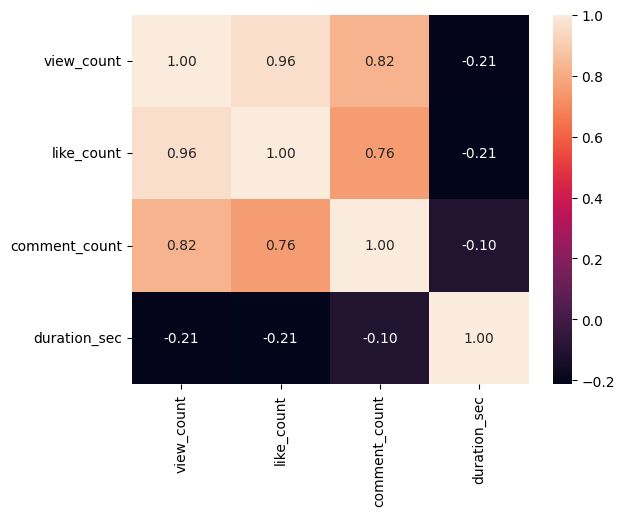

In [38]:
sns.heatmap(video_details[["view_count","like_count","comment_count", "duration_sec"]].corr(),
            annot=True,
            fmt=".2f")

## 1.) Regression: Direct formula (Views vs Likes)

**Regression equation**:
$$y_{i} = \beta_{0}+\beta_{1}x_{i}+\varepsilon_{i}$$

**Estimation of beta values**
$$\beta_{1} = \frac{SS_{xy}}{SS_{xx}}$$

$$\beta_{0} = \bar{y}-\beta_{1}\bar{x}$$
where...
$$SS_{xy} = \sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y}) = \sum_{i=1}^{n}x_{i}y_{i} - n\bar{x}\bar{y}$$

$$SS_{xx} = \sum_{i=1}^{n}(x_{i}-\bar{x})^2 = \sum_{i=1}^{n}x_{i}^2 - n(\bar{x})^2$$

In [75]:
def get_regression_coeff(x, y):
    n = len(x)

    x_mean = x.mean()
    y_mean = y.mean()

    ss_xy = sum(x*y) - n*x_mean*y_mean
    ss_xx = sum(x**2) - n*(x_mean**2)

    beta_1 = ss_xy/ss_xx
    beta_0 = y_mean - beta_1*x_mean

    return beta_0, beta_1

In [76]:
X = video_details["view_count"]
y = video_details["like_count"]

In [77]:
beta = get_regression_coeff(X, y)

In [78]:
print("""beta_0 = {:.4f}
beta_1 = {:.4f}""".format(beta[0], beta[1]))

beta_0 = -50.3276
beta_1 = 0.0449


In [79]:
y_pred = beta[0] + beta[1]*X

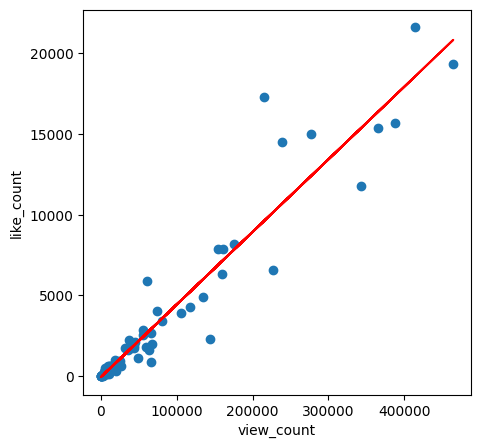

In [80]:
f, axs = plt.subplots(figsize=(5,5))
plt.scatter(X, y)
plt.plot(X, y_pred, color="r")

plt.xlabel("view_count")
plt.ylabel("like_count")
plt.show()

## 2.) Regression: Scikit (Views vs Likes)

In [136]:
X = video_details[["view_count"]]
y = video_details["like_count"]

### 2a.) All Data

In [137]:
linear_reg = linear_model.LinearRegression()

In [138]:
linear_reg.fit(X, y)

LinearRegression()

In [139]:
print("""Intercept = {:.4f}
Coefficient = {:.4f}""".format(linear_reg.intercept_, linear_reg.coef_[0]))

Intercept = -50.3276
Coefficient = 0.0449


In [140]:
y_pred = linear_reg.predict(X)

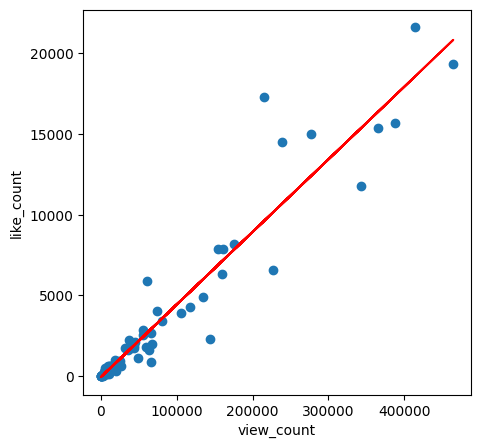

In [141]:
f, axs = plt.subplots(figsize=(5,5))
plt.scatter(X, y)
plt.plot(X, y_pred, color="r")

plt.xlabel("view_count")
plt.ylabel("like_count")
plt.show()

### 2b.) Train Data only

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [155]:
linear_reg = linear_model.LinearRegression()

In [156]:
linear_reg.fit(X_train, y_train)

LinearRegression()

In [157]:
y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

In [158]:
print("""Intercept = {:.4f}
Coefficient = {:.4f}
R2 = {:.4f}
Adj R2 = {:.4f}""".format(linear_reg.intercept_,
                          linear_reg.coef_[0],
                          linear_reg.score(X_test, y_test),
                          adj_r2_score(y_test, y_test_pred, X_test)
                         ))

Intercept = -105.5210
Coefficient = 0.0456
R2 = 0.8600
Adj R2 = 0.8555


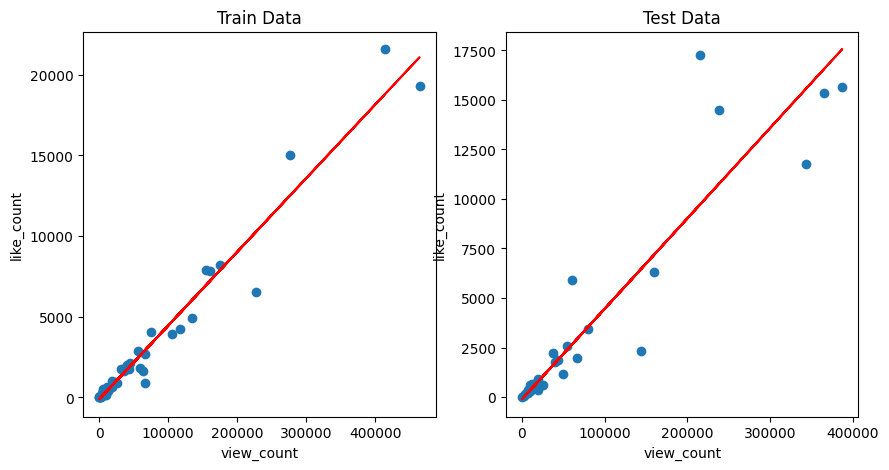

In [159]:
f, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].scatter(X_train, y_train)
axs[0].plot(X_train, y_train_pred, color="r")
axs[0].set_title('Train Data')
axs[0].set(xlabel='view_count', ylabel='like_count')

axs[1].scatter(X_test, y_test)
axs[1].plot(X_test, y_test_pred, color="r")
axs[1].set_title('Test Data')
axs[1].set(xlabel='view_count', ylabel='like_count')

plt.show()

## 3.) Regression: Scikit (Views vs Likes, Comments, Duration)

In [160]:
X = video_details[["view_count", "comment_count", "duration_sec"]]
y = video_details["like_count"]

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [162]:
linear_reg = linear_model.LinearRegression()

In [163]:
linear_reg.fit(X_train, y_train)

LinearRegression()

In [164]:
y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

In [165]:
print("""Intercept = {:.4f}
Coefficient = {:.4f}
R2 = {:.4f}
Adj R2 = {:.4f}""".format(linear_reg.intercept_,
                          linear_reg.coef_[0],
                          linear_reg.score(X_test, y_test),
                          adj_r2_score(y_test, y_test_pred, X_test)
                         ))

Intercept = 30.4162
Coefficient = 0.0531
R2 = 0.8518
Adj R2 = 0.8365


## 4.) Regression: statsmodels (Views vs Likes, Comments, Duration)

In [180]:
X = video_details[["view_count", "comment_count", "duration_sec"]]
y = video_details["like_count"]

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [182]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [183]:
ols_model = sm.OLS(y_train, X_train).fit()
ols_model

In [184]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             like_count   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     691.7
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           1.86e-52
Time:                        21:41:47   Log-Likelihood:                -598.97
No. Observations:                  75   AIC:                             1206.
Df Residuals:                      71   BIC:                             1215.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            30.4162    138.659      0.219      0.827    -246.062     306.894
view_count        0.0531      0.003     21.007      0.000       0.048       0.058
comment_count    -6.7255      2.103     -3.198      0.002     -10.918      -2.533
duration_sec      0.0423      0.070      0.602      0.549      -0.098       0.183
==============================================================================
Omnibus:                       45.364   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.364
Skew:                          -1.614   Prob(JB):                     1.30e-56
Kurtosis:                      11.481   Cond. No.                     1.56e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [190]:
y_train_pred = ols_model.predict(X_train)
y_test_pred = ols_model.predict(X_test)

In [193]:
print("""R2 = {:.4f}
Adj R2 = {:.4f}""".format(r2_score(y_test, y_test_pred),
                          adj_r2_score(y_test, y_test_pred, X_test)
                         ))

R2 = 0.8518
Adj R2 = 0.8307
